In [10]:
%%time

import scipy.integrate as integrate
from scipy.integrate import solve_ivp
import numpy as np

# This controls which part of the assignment we will be solving for
mode = 'galaxy'

# Sets all of the constants needed
if mode == 'solar':
    G = 6.6e-11 # N m^2/kg^2

    ### The following section contains the initial postions, velocities and masses for the four bodies.
    
    sun_r0 = np.array([0.0, 0.0, 0.0]) # m
    sun_v0 = np.array([0.0, 0.0, 0.0]) # m/s
    sun_M = 2e30 # kg
    
    earth_r0 = np.array([149.6e9, 0.0, 0.0]) # m
    earth_v0 = np.array([0.0, 29.8e3, 0.0]) # m/s
    earth_M = 5.97e24 # kg
    
    venus_r0 = np.array([108e9, 0.0, 0.0])
    venus_v0 = np.array([0.0, 35e3, 0.0])
    venus_M = 5e24
    
    mars_r0 = np.array([230e9, 0.0, 0.0])
    mars_v0 = np.array([0.0, 24e3, 0.0])
    mars_M = 6.4e23

    # A regularisation term for the force calculation.
    a = 1e-20

    # The end point of simulation, this is 10 years
    t_max = 31557600.0*10 # s

    # How far out to plot our visualisation later
    vis_radius = 300e9 # m

elif mode == 'galaxy':
    G = 4.49e-18 # kpc^3/M_solar/kyear^2

    # Some constants for generating the locations of the bodies
    R_gen = 50 # kpc
    z_scale_factor = 0.25
    N_bodies = 200
    M_bodies = 1e8 # M_solar
    rc = 1 # kpc

    # The end point of the simulation, this is 1 billion years
    t_max = 1000000 # kyr

    # How far out the visualisation should go
    vis_radius = 50 # kpc

else:
  print("Invalid mode")

CPU times: user 4.53 ms, sys: 0 ns, total: 4.53 ms
Wall time: 4.68 ms


In [11]:
"""
sun_r0 = np.array([0.0, 0.0, 0.0]) # m
    sun_v0 = np.array([0.0, 0.0, 0.0]) # m/s
    sun_M = 2e30 # kg
    
    earth_r0 = np.array([149.6e9, 0.0, 0.0]) # m
    earth_v0 = np.array([0.0, 29.8e3, 0.0]) # m/s
    earth_M = 5.97e24 # kg
    
    venus_r0 = np.array([108e9, 0.0, 0.0])
    venus_v0 = np.array([0.0, 35e3, 0.0])
    venus_M = 5e24
    
    mars_r0 = np.array([230e9, 0.0, 0.0])
    mars_v0 = np.array([0.0, 24e3, 0.0])
    mars_M = 6.4e23
Functions to provide the plot kwargs in the two cases."""
from __future__ import annotations
def solar_plot_params(body_names: list[str], size_factor: float = 1) -> dict[str, list]:
    """
    Get the color and size key-word argument arrays for the solar system.

    The body names provides the order of the bodies in the plot to ensure proper matching

    Parameters
    ----------
    body_names : list[str]
        Order of bodies as simulated
    size_factor : float, optional
        Multiplicative factor to adjust size (area) of all bodies in plot, by default 1

    Returns
    -------
    dict[str, list]
        Unpack output from this function with ** into ax.scatter.
    """
    # Note sizes are area, not radius
    solar_sizes = {
        "sun": 50,
        "earth": 28,
        "venus": 24,
        "mars": 20,
    }
    solar_colours = {
        "sun": "yellow",
        "earth": "blue",
        "venus": "orange",
        "mars": "red",
    }
    res = {"s":[],"c":[]}
    for body in body_names:
        body = body.lower()
        res["s"].append(solar_sizes[body] * size_factor)
        res["c"].append(solar_colours[body])
    return res

def galaxy_plot_params(n_bodies: int, cmap: str = "hsv", map_range: tuple[float] = (0,1), size: int = 7):
    """
    Get the colour, size and cmap key-word argument values for the galaxy simulation.

    Map range allows the accessing of a subset of a colormap through a range narrower than (0,1).
    See https://matplotlib.org/stable/users/explain/colors/colormaps.html for more colormaps.

    Parameters
    ----------
    n_bodies : int
        Number of bodies in galaxy.
    cmap : str, optional
        Color map to use, by default "hsv"
    map_range : tuple[float], optional
        Subset of colormap to randomly sample, by default (0,1)
    size : int, optional
        Area of bodies, by default 7

    Returns
    -------
    _type_
        _description_
    """
    res = {
        "s": size,
        "c": np.random.uniform(*map_range, size=n_bodies), 
        "cmap": cmap,
    }
    return res

In [12]:
# get rs and vs from the flattened y array
def get_rs_vs(y_flat):
  rs, vs = y_flat.reshape(y0.shape)
  return rs, vs

# Return the squared length of a vector
def lengthSquared(vec):
  return np.sum(vec**2, axis = -1)

# Calculate the velocity and acceleration on each body after each timestep
def dy_dt(t, y_flat):
  # Obtain 2 vectors, containing the position vectors and velocity vectors
  rs, vs = get_rs_vs(y_flat)

  # Define the derivative of the position to be the velocity
  drs_dt = vs

  # Initialise an empty array to contain the total acceleration of each body
  a_vector = np.zeros_like(vs)

  # Loop over each body
  for i in range(0, len(masses)):
    # The difference between two positions
    delta_r = rs - rs[i]

    # Calculate the squared difference and magnitude between two positions
    delta_r_squared = lengthSquared(delta_r) + a**2 # a = regularisation term for force calculation
    delta_r_magnitude = delta_r_squared ** (3/2)

    # Calculate an array consisting of the forces from other bodies onto the current body
    force_magnitude = G * masses / delta_r_magnitude
    force_vector = force_magnitude[:, None] * delta_r

    # Sum up all forces on the body to get the final acceleration value of the body
    a_vector[i] = np.sum(force_vector, axis = 0)

  # Define the derivative of the velocity to be the acceleration
  dvs_dt = a_vector

  # Return the change in position and the change in velocity
  return np.array([drs_dt, dvs_dt]).flatten()

# Pre initialize solution so that whether solar or galaxy is chosen the solution will be saved into this variable
solution = 0

In [ ]:
# Only do the following if solar is chosen
if mode == "solar":
    
    # Create a numpy array with all the initial positions and velocities of the four bodies
    y0 = np.array([[sun_r0, venus_r0, earth_r0, mars_r0], [sun_v0, venus_v0, earth_v0, mars_v0]])


    # Create a numpy array with all four constant masses of the bodies
    masses = np.array([sun_M, venus_M, earth_M, mars_M])

    # Defining the amount of time steps we're interested in
    time_points = 200
    # Create a linspace of timesteps with values from the initial time to the maximum time
    t_grid = np.linspace(0, t_max, time_points)
    t_span = (0, t_max)

    # Compute the ivp using the BDF method and save the solution
    solution = solve_ivp(dy_dt, t_span, y0.flatten(), t_eval=t_grid, method='BDF', rtol=1e-8)

In [ ]:
# Only do the following if galaxy is chosen
if mode == "galaxy":

    def generatePositions(N_bodies, R):
        epsilon_phi = np.random.rand(N_bodies)
        epsilon_theta = np.random.rand(N_bodies)
        epsilon_rad = np.random.rand(N_bodies)

        phi = 2 * np.pi * epsilon_phi
        theta = np.arccos(1 - (2 * epsilon_theta))
        rad = R * epsilon_rad ** (1/3)

        r_1 = rad * np.sin(theta) * np.cos(phi)
        r_2 = rad * np.sin(theta) * np.sin(phi)
        r_3 = rad * np.cos(theta)

        v_1 = np.zeros(N_bodies)
        v_2 = np.zeros(N_bodies)
        v_3 = np.zeros(N_bodies)

        return np.array([[r_1, r_2, r_3], [v_1, v_2, v_3]])
    
    a = rc*(2**(2/5) - 1)**(-1/2)
    y0 = generatePositions(N_bodies, R_gen)



    

[[[ -8.73650814   1.20817695  26.60978693 ...   3.74653989 -34.48213597
    26.63018271]
  [  4.63232384  10.60361923  30.70153718 ... -17.73185553  18.62020019
   -17.36711015]
  [-37.40765315  48.54955208  -8.7871275  ...  41.48468705 -15.9950856
   -38.10734891]]

 [[  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]]]
[[[0.000e+00 0.000e+00 0.000e+00]
  [1.080e+11 0.000e+00 0.000e+00]
  [1.496e+11 0.000e+00 0.000e+00]
  [2.300e+11 0.000e+00 0.000e+00]]

 [[0.000e+00 0.000e+00 0.000e+00]
  [0.000e+00 3.500e+04 0.000e+00]
  [0.000e+00 2.980e+04 0.000e+00]
  [0.000e+00 2.400e+04 0.000e+00]]]


In [ ]:
# Return the total energy of the system
def getTotalEnergy(y_flat):
    # Obtain positions and velocities of bodies
    rs, vs = get_rs_vs(y_flat)

    # Initialize kinetic energy
    E_kinetic_total = 0

    # Initialize potential energy
    E_potential_total = 0

    # Loop over each body i
    for i in range(0, len(m)):
        # Calculate kinetic energy of body
        E_kinetic_total += (1/2) * m[i] * lengthSquared(vs[i])

        # Loop over each body j
        for j in range(0, len(m)):
            if j < i:
                E_potential_total += -G * m[i] * m[j] / np.sqrt(lengthSquared(rs[j] - rs[i]))

    # Calculate total energy
    E_total = E_kinetic_total + E_potential_total
    return E_total

if mode == "solar":
    # Initialize array of energy
    E_vector = np.zeros(time_points)
    # Calculate total energy for each timestep
    for i in range(0, time_points):
        E_vector[i] = getTotalEnergy(solution.y[:, i])
        # print(f"t = {i}, E = {Energy[i]}")

        # print(E_vector[i])

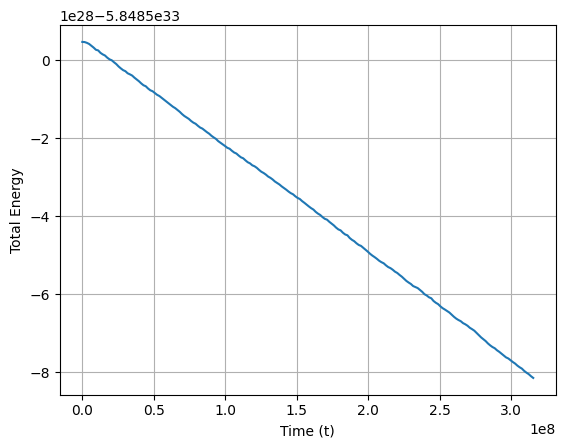

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(t_grid, E_vector)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Total Energy")
ax.grid(True)
plt.show()

In [17]:
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib as mpl

def get_body_coordinates(t):
    """
    Returns the coordinates of each body in a tuple. If we are simulating a solar system then 
    only the x and y coordinates are returned.

    Parameters
    ----------
    t : int
        The time step for which the body coordinates should be returned, where 0 is the first time step.
    """
    #########################
    # Fill in the dots below with the output of your simulation
    # Take your 'solution_y_t', index it with the 't' argument of this function, 
    # and use it to get the x, y, and z coordinates of the simulation bodies.
    #########################
    
    body_x_coordinates = solution.y[:, t].reshape(y0.shape)[0][:,0]
    body_y_coordinates = solution.y[:, t].reshape(y0.shape)[0][:,1]
    if mode == 'solar':
        return body_x_coordinates, body_y_coordinates, None
    elif mode == 'galaxy':
        body_z_coordinates = solution.y[:, t].reshape(y0.shape)[0][:,2]
        return body_x_coordinates, body_y_coordinates, body_z_coordinates

plt.rcParams["animation.html"] = "jshtml" # Makes animations work better in a notebook
plt.rcParams['figure.dpi'] = 100 # Sets the size of the animation in dots per inch
plt.ioff()

plt.close() # Ensure we get a fresh canvas
fig = plt.figure() # Create a new figure to animate in

# First we initiate the plot using the first time slice
body_init_x_coordinates, body_init_y_coordinates, body_init_z_coordinates = get_body_coordinates(0)
# Actually plotting the data, note that we collect the output from scatter
if mode == 'solar':
    ax = plt.axes() # standard 2D axes for the solar system
    # solar_plot_params contains colour and size arguments
    plot_kwargs = solar_plot_params(["sun","venus","earth","mars"], size_factor=2)
    # 2D scatter plot of the x and y coordinates of the solar system bodies
    bodies = ax.scatter(body_init_x_coordinates, body_init_y_coordinates, **plot_kwargs)
elif mode == 'galaxy':
    ax = plt.axes(projection='3d') # 3D axes for the galaxy simulation
    # Size and colour again
    plot_kwargs = galaxy_plot_params(N_bodies,cmap="spring",map_range=(0.6,0.7), size=12)
    # Similar to the solar system case, but this 3D scatter plot has three inputs: x, y, and z
    bodies = ax.scatter(body_init_x_coordinates, body_init_y_coordinates, body_init_z_coordinates, **plot_kwargs)

# Finish initialisation by setting the bounds and labels
axis_lim = 0
if mode == "solar":
    axis_lim = 300e9 # m
    ax.set_xlim(-axis_lim,axis_lim)
    ax.set_xlabel("x")
    ax.set_ylim(-axis_lim,axis_lim)
    ax.set_ylabel("y")
if mode == 'galaxy':
    axis_lim = 50 * 1.54283879e21 # m
    ax.set_xlim(-axis_lim,axis_lim)
    ax.set_xlabel("x")
    ax.set_ylim(-axis_lim,axis_lim)
    ax.set_ylabel("y")
    ax.set_zlim(-axis_lim,axis_lim)
    ax.set_zlabel("z")
ax.set_aspect('equal') # Ensure we get a square plot

def animate(t):
    """
    Animation function, at any given timestep returns the updated 'artists' bodies so that the animator
    can update the plot.
    """
    body_x_coordinates, body_y_coordinates, body_z_coordinates = get_body_coordinates(t+1)
    # Now we update the coordinates. They are called offsets underneath for a scatter plot
    if mode == 'solar':
        # Set offsets requires an (N, 2) array
        bodies.set_offsets(np.array([body_x_coordinates, body_y_coordinates]).T)
    elif mode == 'galaxy':
        # No setter method exists for 3d so we set the points manually        
        bodies._offsets3d = (body_x_coordinates, body_y_coordinates, body_z_coordinates)

    # We also spin the plot inside
    if mode == 'galaxy':
        # We only set the z limits and camera rotation for a 3D plot
        ax.azim = ax.azim + 0.2
    
    return bodies, # Must return a tuple or list of the 'artists', the comma ensures this is a tuple

# By passing blit=True, we are telling FuncAnimation that our animate function will return the artists with
# the changed data. As a result it automatically only updates the relevant parts of the plot.
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=(len(solution.y.T) - 1), interval = 100, blit=True)
plt.close()
anim

AttributeError: 'int' object has no attribute 'y'